## Behavioral Data Analysis

#### Created on 07/25/2023 <br/> Created by Daon Lee (onlyforres@gmail.com)

In [2]:
### preparation

import os
import glob
import numpy as np
import pandas as pd


### set path: bhv or physio 여부 변경 필!

datapath = r'/Users/daonly/Library/Mobile Documents/com~apple~CloudDocs/Res/Conformity/data/bhv'
savepath = r'/Users/daonly/Library/Mobile Documents/com~apple~CloudDocs/Res/Conformity/analysis/bhv'

#datapath = r'C:\Users\LSD\Desktop\Res\Conformity\data\bhv'
#savepath = r'C:\Users\LSD\Desktop\Res\Conformity\analysis\bhv'

print(pd.__version__)
print(np.__version__)

2.1.3
1.24.1


### Dilemma Task Data Reconstruction

In [5]:
### calculate group consensus for initDist

from scipy.stats import pearsonr

taskname = 'Dilemma'

scendf = pd.DataFrame()

lists = {f'list{i}': [] for i in range(1, 41)}
listbs = {f'list{i}b': [] for i in range(1, 41)}

for i in range(23, 96):
    if i == 33 or i == 38 or i == 68 or i == 75 or i == 79:
        continue 
        
    globals()["adjdf{}".format(i)] = pd.read_excel(datapath+f'/adj{taskname}-{i}.xlsx', header=0, usecols=range(1, 17))
    rawdf = globals()[f'adjdf{i}']

    for j in range(1, 41):
        for index, row in rawdf.iterrows():
            if type(row['TrialNum']) == int and row['snNum'] == j:
                lists[f'list{j}'].append(row['quesResp'])
                listbs[f'list{j}b'].append(row['quesBina'])

for k in range(1, 41):
    scendf.loc[k, 'snNum'] = k
    scendf.loc[k, 'avg_dec'] = np.mean(lists[f'list{k}'])
    scendf.loc[k, 'avg_dec_bin'] = np.mean(listbs[f'list{k}b'])
    
savefile = f'{datapath}/Main/initDist.xlsx'
scendf.to_excel(savefile, index=False, header=True, startrow=0)
print("Complete")

Complete


In [22]:
### group bhv data setting w/ PE & confidence

from scipy.stats import pearsonr
#import warnings

#warnings.filterwarnings("ignore", category=RuntimeWarning)  ##conflict 있으면 HL는 비어 있는 게 당연해서 경고 끔

taskname = 'Dilemma'

scendf1 = pd.read_excel(datapath+'/Main/scenarios_1.xlsx')
scendf2 = pd.read_excel(datapath+'/Main/scenarios_2.xlsx')
pardf = pd.read_excel(datapath+'/Main/Participants.xlsx')
bhvdf = pd.DataFrame()

for i in range(23, 96):
    if i == 33 or i == 38 or i == 68 or i == 75 or i == 79:
        continue 
        
    globals()["adjdf{}".format(i)] = pd.read_excel(datapath+f'/Main/encDilemma/enc{taskname}-{i}.xlsx', header=0)
    rawdf = globals()[f'adjdf{i}']
    
    ## SubID
    SubID = str(rawdf.loc[1,'SubID'])
    bhvdf.loc[i, 'SubID'] = SubID
    
    ## individual data
    for index, row in pardf.iterrows():
        if row['SubID'] == i:
            bhvdf.loc[i, 'age'] = row['age']
            bhvdf.loc[i, 'sex'] = str(row['sex'])
            
    ## cardiac data
    for index, row in pardf.iterrows():
        if row['SubID'] == i:
            bhvdf.loc[i, 'IAcc'] = row['IAcc']
            bhvdf.loc[i, 'IAw'] = row['IAw']

    
    ## absChange
    bhvdf.loc[i, 'meanConf'] = np.mean(rawdf['meanConf'])
                                      
    
savefile = f'{datapath}/Main/allData.xlsx'
bhvdf.to_excel(savefile, index=False, header=True, startrow=0)
print("Complete")

Complete


In [7]:
### for GLMM

taskname = 'Dilemma'

scendf2 = pd.read_excel(datapath+'/Main/scenarios_2.xlsx')
encdf = pd.DataFrame()

## encDilemma-summary

for i in range(23, 96):
    if i == 33 or i == 38 or i == 68 or i == 75 or i == 79:
        continue 
        
    globals()["adjdf{}".format(i)] = pd.read_excel(datapath+f'/adj{taskname}-{i}.xlsx', header=0, usecols=range(1, 19))
    rawdf = globals()[f'adjdf{i}']
    
    df = rawdf[['TrialNum', 'TrialNum2', 'snNum', 'quesResp']]
    list1, list2, list3, list4 = [], [], [], []
    for index, row in df.iterrows():
        if type(row['TrialNum']) == int:
            list1.append(row['snNum'])
            list2.append(row['quesResp'])
        elif type(row['TrialNum2']) == int:
            list3.append(row['snNum'])
            list4.append(row['TrialNum2'])
    df1 = pd.DataFrame({'snNum1': list1, 'quesResp1': list2})
    df2 = pd.DataFrame({'snNum2': list3, 'trialNum2':list4})
    df1 = df1.sort_values(by='snNum1'); df2 = df2. sort_values(by='snNum2')
    df1 = df1.set_index('snNum1'); df2 = df2.set_index('snNum2')
    df = pd.concat([df1['quesResp1'], df2['trialNum2']], axis=1).sort_values(by='trialNum2')
    df['initRate'] = df['quesResp1']
    rawdf['initRate'] = None
    rawdf.loc[43:82, 'initRate'] = df['initRate'].values
    
    rawdf = rawdf.drop(list(range(48))+[57, 63, 75, 81, 82, 83, 84]).reset_index(drop=True)
    rawdf = rawdf[['SubID', 'TrialNum2', 'snDiff', 'initRate', 'quesResp', 'quesRTZ', 'quesUtil', 'trend', 'PE', 'absPE', 'change', 'drift']]

    rawdf['absChan'] = rawdf['change'].apply(np.abs)

    ## diff
    list1 = []
    for index, row in rawdf.iterrows():
        if row['snDiff'] == 'easy':
            list1.append(10)
        elif row['snDiff'] == 'normal':
            list1.append(20)
        elif row['snDiff'] == 'hard':
            list1.append(30)
    df = pd.DataFrame({'diff': list1})
    rawdf = pd.concat([rawdf, df], axis=1)
    
    ## adjQuesUtil
    list1 = []
    for index, row in rawdf.iterrows():
        if row['quesUtil'] == 0:
            list1.append(-10)
        elif row['quesUtil'] == 1:
            list1.append(10)
    df = pd.DataFrame({'adjQuesUtil': list1})
    rawdf = pd.concat([rawdf, df], axis=1)
    
    ## rateUtil
    list1 = []
    for index, row in rawdf.iterrows():
        if row['quesUtil'] == 0 and row['quesResp'] < 50:
            list1.append(10)
        elif row['quesUtil'] == 1 and row['quesResp'] >= 50:
            list1.append(10)
        else:
            list1.append(-10)
    df = pd.DataFrame({'rateUtil': list1})
    rawdf = pd.concat([rawdf, df], axis=1)
    
    encdf = pd.concat([encdf, rawdf], axis=0)
    
encdf = encdf[['SubID', 'TrialNum2', 'diff', 'initRate', 'quesResp', 'PE', 'absPE', 'trend', 'absChan', 'drift', 'quesRTZ', 'adjQuesUtil', 'rateUtil']]  
encdf = encdf.rename(columns={'quesResp': 'finaRate'})
encdf['confidence'] = encdf['initRate'].apply(lambda x: x - 50 if x > 50 else 50 - x)
encdf['conflict'] = np.where(
    ((encdf['initRate'] <= 50) & (encdf['trend'] <= 50)) | ((encdf['initRate'] >= 50) & (encdf['trend'] >= 50)), 
    -10, 
    10
)

encdf['personal'] = None
for idx, enc_row in encdf.iterrows():
    matching_rows = scendf2[scendf2['order2'] == enc_row['TrialNum2']]
    if not matching_rows.empty:
        encdf.at[idx, 'personal'] = matching_rows.iloc[0]['JY_personal']


savefile = f'{datapath}/Main/encDilemma.xlsx'
encdf.to_excel(savefile, index=False, header=True, startrow=0)
print("Complete")

Complete


### Bhv Data Analyses

In [18]:
### regression plots
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from itertools import combinations

conds = ['stanIAw', 'initDist', 'absChan']

for cond1, cond2 in combinations(conds, 2):
    corr, p_value = stats.pearsonr(corrdf[f'{cond1}'], corrdf[f'{cond2}'])
    p_value = p_value/2
    comparison = f'{cond1} & {cond2}'
    goal.append({'Pair': comparison, 'corr': corr, 'p_value': p_value})
    
    sns.regplot(
        x=cond1, y=cond2, data=corrdf,
        scatter_kws={'color': '#808080', 's': 30, 'alpha': 0.7},  
        line_kws={'color': '#0375C9', 'linewidth': 2},  
    )
    plt.xlabel(f'{cond1}')
    plt.ylabel(f'{cond2}')
    plt.savefig(savepath+f'{cond1}_{cond2}')
    plt.close()

print("Complete")

Complete


### Non-linear Relationship

=== Linear Regression ===
MSE: 0.0349, R²: 0.0684

=== Quadratic Regression ===
MSE: 0.0324, R²: 0.1340
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     5.029
Date:                Tue, 08 Apr 2025   Prob (F-statistic):            0.00931
Time:                        12:46:13   Log-Likelihood:                 20.066
No. Observations:                  68   AIC:                            -34.13
Df Residuals:                      65   BIC:                            -27.47
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

/Users/daonly/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


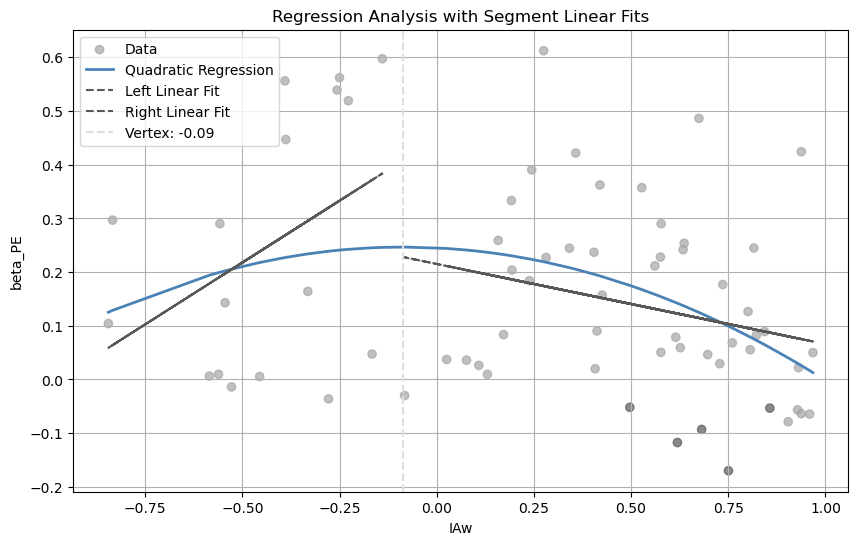


Complete!


In [12]:
#### Non-linear Fitting: betaPE ~ IAw

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import scipy.stats as stats

# 데이터 불러오기
data = pd.read_excel('/Users/daonly/Library/Mobile Documents/com~apple~CloudDocs/Res/Conformity/data/PE_IAw.xlsx')
X = data['IAw'].values.reshape(-1, 1)
y = data['beta_PE'].values


### 1. 선형 회귀
linear_model = LinearRegression()
linear_model.fit(X, y)
linear_y_pred = linear_model.predict(X)

linear_mse = mean_squared_error(y, linear_y_pred)
linear_r2 = r2_score(y, linear_y_pred)

### 2. 다항 회귀 (2차)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
X_poly_const = sm.add_constant(X_poly)

poly_model = sm.OLS(y, X_poly_const).fit()
beta_0, beta_1, beta_2 = poly_model.params
poly_y_pred = poly_model.predict(X_poly_const)

poly_mse = mean_squared_error(y, poly_y_pred)
poly_r2 = r2_score(y, poly_y_pred)

# 극값(vertex)
vertex = -beta_1 / (2 * beta_2)
vertex_in_range = X.min() <= vertex <= X.max()
beta_2_p_value = poly_model.pvalues[2]

print("=== Linear Regression ===")
print(f"MSE: {linear_mse:.4f}, R²: {linear_r2:.4f}")
print("\n=== Quadratic Regression ===")
print(f"MSE: {poly_mse:.4f}, R²: {poly_r2:.4f}")
print(poly_model.summary())
print(f"Quadratic Term (β₂): {beta_2:.4f}, p-value: {beta_2_p_value:.4f}")

if beta_2 > 0:
    u_type = "U-shape"
elif beta_2 < 0:
    u_type = "Inverted U-shape"
else:
    u_type = "None"
print(f"\nDetected Shape: {u_type}")

### 3. 좌/우 분할 회귀 분석
left_data = data[data['IAw'] <= vertex]
right_data = data[data['IAw'] > vertex]

# 좌측
if not left_data.empty:
    X_left = left_data['IAw'].values.reshape(-1, 1)
    y_left = left_data['beta_PE'].values
    left_model = sm.OLS(y_left, sm.add_constant(X_left)).fit()
    left_slope = left_model.params[1]
    left_p = left_model.pvalues[1]
    print("\n=== Left Linear Regression ===")
    print(left_model.summary())
else:
    left_model = None
    left_slope = None
    left_p = None
    print("\nNo data for left-side regression.")

# 우측
if not right_data.empty:
    X_right = right_data['IAw'].values.reshape(-1, 1)
    y_right = right_data['beta_PE'].values
    right_model = sm.OLS(y_right, sm.add_constant(X_right)).fit()
    right_slope = right_model.params[1]
    right_p = right_model.pvalues[1]
    print("\n=== Right Linear Regression ===")
    print(right_model.summary())
else:
    right_model = None
    right_slope = None
    right_p = None
    print("\nNo data for right-side regression.")

# F-test
if left_model is not None and right_model is not None:
    f_stat = ((left_slope - right_slope) ** 2) / (left_model.bse[1] ** 2 + right_model.bse[1] ** 2)
    df1 = 1
    df2 = left_model.df_resid + right_model.df_resid
    f_p_value = 1 - stats.f.cdf(f_stat, df1, df2)
    print(f"\n=== F-Test Between Left and Right Slopes ===")
    print(f"F-statistic: {f_stat:.4f}, p-value: {f_p_value:.4f}")
else:
    f_stat = None
    f_p_value = None

### 4. 그래프 그리기
data['Color'] = data['sigCorr'].map({0: '#A6A6A6', 1: '#595959'})
#data['Color'] = data['absChan_bin'].map({0: '#A6A6A6', 1: '#595959'})
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color=data['Color'], label='Data', alpha=0.7)

# 선형 회귀선
#plt.plot(X, linear_y_pred, color='#4B82B6', label='Linear Regression', linewidth=2)

# 2차 회귀 곡선
X_sorted = np.sort(X, axis=0)
X_sorted_poly = poly.transform(X_sorted)
y_sorted_poly_pred = poly_model.predict(sm.add_constant(X_sorted_poly))
#plt.plot(X_sorted, y_sorted_poly_pred, color='#4B82B6', label=f'Quadratic Regression ({u_type})', linewidth=2)
plt.plot(X_sorted, y_sorted_poly_pred, color='#4B82B6', label=f'Quadratic Regression', linewidth=2)

# 좌/우 회귀선
if left_model is not None:
    plt.plot(X_left, left_model.predict(sm.add_constant(X_left)), color='#595959', linestyle='--', label='Left Linear Fit')
if right_model is not None:
    plt.plot(X_right, right_model.predict(sm.add_constant(X_right)), color='#595959', linestyle='--', label='Right Linear Fit')

# 극값 수직선
if vertex_in_range:
    plt.axvline(x=vertex, color='#DFDFDF', linestyle='--', label=f'Vertex: {vertex:.2f}')

plt.xlabel('IAw')
plt.ylabel('beta_PE')
plt.title('Regression Analysis with Segment Linear Fits')
plt.legend()
plt.grid(True)
plt.savefig('/Users/daonly/Library/Mobile Documents/com~apple~CloudDocs/Res/Conformity/analysis/bhv/nonlinearity/betaPE_IAw_regression_combined.png')
plt.show()

print("\nComplete!")